# Setup and Data Loading

First, let's set up your environment by importing the necessary libraries and loading the dataset

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, accuracy_score
import joblib


In [2]:
# Load the dataset from the uploaded CSV file
# This assumes 'fertility.csv' is in the same directory as your notebook
df = pd.read_csv('fertility.csv')

# Display the first few rows of the dataframe to understand its structure
print("First 5 rows of the dataset:")
print(df.head())

# Get a concise summary of the dataframe
print("\nDataset Information:")
df.info()

First 5 rows of the dataset:
  user_id      date  day_index  cycle_day    bbt cervical_mucus  is_pcos
0  user_1  1/1/2025          1          1  36.13            Dry    False
1  user_1  1/2/2025          2          2  36.40            Dry    False
2  user_1  1/3/2025          3          3  36.30            Dry    False
3  user_1  1/4/2025          4          4  36.25            Dry    False
4  user_1  1/5/2025          5          5  36.22            Dry    False

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   user_id         9000 non-null   object 
 1   date            9000 non-null   object 
 2   day_index       9000 non-null   int64  
 3   cycle_day       9000 non-null   int64  
 4   bbt             9000 non-null   float64
 5   cervical_mucus  9000 non-null   object 
 6   is_pcos         9000 non-null   bool   


# Feature Engineering

Our dataset doesn't have a direct "fertile" or "not fertile" column, which is our target. We need to create it. The fertile window is typically the 5 days before ovulation plus the day of ovulation. For a standard cycle, ovulation often occurs around day 14.

We will define the fertile window as days 11 through 16 of the cycle. This is a common and effective simplification.

In [3]:
# Create the target variable 'is_fertile'
# We define the fertile window as cycle days 11 to 16, inclusive.
# 1 represents a fertile day, and 0 represents a non-fertile day.
df['is_fertile'] = df['cycle_day'].apply(lambda x: 1 if 11 <= x <= 16 else 0)

# Display the distribution of the new 'is_fertile' column
print("\nDistribution of Fertile vs. Non-Fertile Days:")
print(df['is_fertile'].value_counts())


Distribution of Fertile vs. Non-Fertile Days:
0    7229
1    1771
Name: is_fertile, dtype: int64


# Data Visualization

Visualizing the data helps us understand the patterns, especially the relationship between Basal Body Temperature (BBT) and the menstrual cycle.

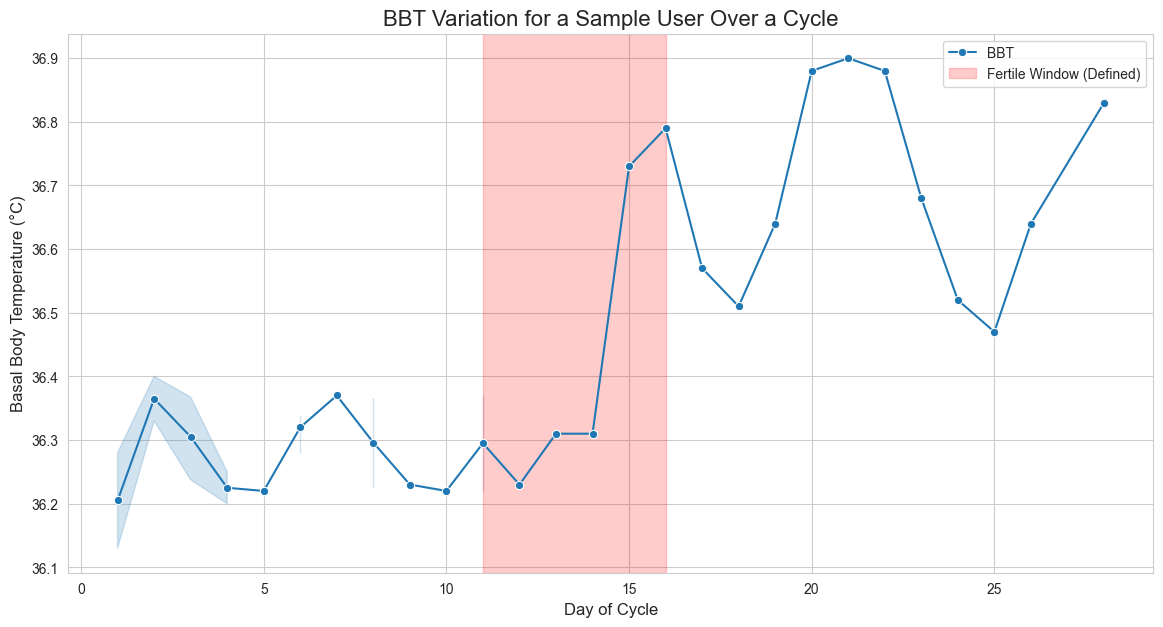

In [4]:
# Set the style for the plots
sns.set_style("whitegrid")
plt.figure(figsize=(14, 7))

# Plot the Basal Body Temperature (BBT) over the cycle for a sample user
sample_user_df = df[df['user_id'] == 'user_1'].head(40) # Limiting to first 40 days for clarity
sns.lineplot(data=sample_user_df, x='cycle_day', y='bbt', marker='o', label='BBT')

# Highlight the fertile window we defined
plt.axvspan(11, 16, color='red', alpha=0.2, label='Fertile Window (Defined)')

# Add titles and labels for clarity
plt.title('BBT Variation for a Sample User Over a Cycle', fontsize=16)
plt.xlabel('Day of Cycle', fontsize=12)
plt.ylabel('Basal Body Temperature (°C)', fontsize=12)
plt.legend()
plt.show()



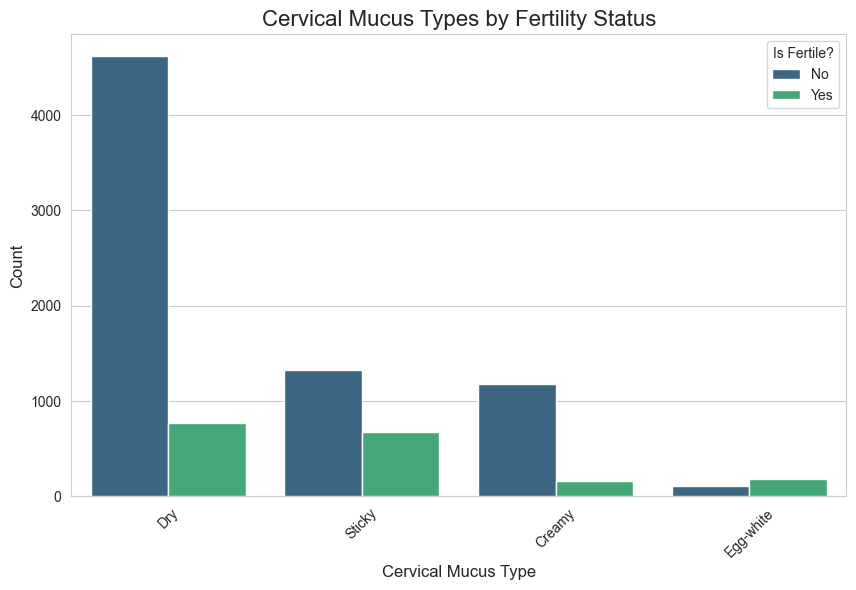

In [5]:
# Visualize the relationship between cervical mucus and the fertile window
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='cervical_mucus', hue='is_fertile', palette='viridis')
plt.title('Cervical Mucus Types by Fertility Status', fontsize=16)
plt.xlabel('Cervical Mucus Type', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Is Fertile?', labels=['No', 'Yes'])
plt.show()

# Data Preprocessing

Machine learning models require all input features to be numeric. We need to convert the categorical 'cervical_mucus' column into a numerical format using one-hot encoding.

In [6]:
# Select the features (X) and the target (y)
# We will use 'cycle_day', 'bbt', and 'cervical_mucus' as our predictors.
features = ['cycle_day', 'bbt', 'cervical_mucus']
target = 'is_fertile'

# Create a copy to avoid modifying the original dataframe during preprocessing
df_model = df[features + [target]].copy()

# Perform one-hot encoding on the 'cervical_mucus' column
# This converts categories into separate columns with 0s and 1s.
df_model = pd.get_dummies(df_model, columns=['cervical_mucus'], drop_first=True)

# Separate features (X) and target (y) after encoding
X = df_model.drop(target, axis=1)
y = df_model[target]

# Store the column names, which will be needed for the Streamlit app
model_columns = X.columns
joblib.dump(model_columns, 'model_columns.pkl')


# Split the data into training and testing sets
# 80% of the data will be for training, and 20% for testing.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nShape of the training data:", X_train.shape)
print("Shape of the testing data:", X_test.shape)


Shape of the training data: (7200, 5)
Shape of the testing data: (1800, 5)


# Model Training and Evaluation

Here, we will train three different models, including the requested ensemble model (Random Forest). We'll evaluate each one to see how well they perform.

In [7]:
# Initialize the models
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=100, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=100, random_state=42)
}

# Dictionary to store the results
results = {}

# Loop through the models to train and evaluate them
for name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)

    # Make predictions on the test data
    y_pred = model.predict(X_test)

    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)

    # Get the classification report
    report = classification_report(y_test, y_pred)

    # Store the results
    results[name] = {
        'accuracy': accuracy,
        'report': report
    }

In [8]:
# Print the classification reports and accuracy for each model
for name, result in results.items():
    print(f"{name}")
    print(f"Accuracy: {result['accuracy']:.4f}")
    print("Classification Report:")
    print(result['report'])
    print("\n")

Logistic Regression
Accuracy: 0.8511
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.97      0.91      1446
           1       0.75      0.37      0.49       354

    accuracy                           0.85      1800
   macro avg       0.80      0.67      0.70      1800
weighted avg       0.84      0.85      0.83      1800



Random Forest
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1446
           1       1.00      1.00      1.00       354

    accuracy                           1.00      1800
   macro avg       1.00      1.00      1.00      1800
weighted avg       1.00      1.00      1.00      1800



Gradient Boosting
Accuracy: 1.0000
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1446
           1       1.00      1.00      1.00       354

    ac

# Saving the Best Model

To deploy the model in a Streamlit webapp, we would save the trained model to a file. We'll use the joblib library for this.

In [9]:
# # Select the best model (Random Forest is a great choice)
# best_model = models['Random Forest']

# # Save the trained model to a file named 'fertility_model.pkl'
# joblib.dump(best_model, 'fertility_model.pkl')

# print("Model saved successfully as 'fertility_model.pkl'")

In [10]:
# Select the best model (Logistic Regression is a great choice)
best_model = models['Logistic Regression']

# Save the trained model to a file named 'fertility_model.pkl'
joblib.dump(best_model, 'model_fertility.pkl')

print("Model saved successfully as 'model_fertility.pkl'")

Model saved successfully as 'model_fertility.pkl'


# Creating a Function to Test the Model

Here we would load our saved model and use it to predict fertility for new, single-instance data, just like we would the Streamlit webapp.

In [10]:
# Load the saved model and the column list
loaded_model = joblib.load('fertility_model.pkl')
model_columns = joblib.load('model_columns.pkl')

def predict_fertility(cycle_day, bbt, cervical_mucus):
    """
    Predicts fertility status based on user input.
    """
    # Create a dictionary for the new data
    new_data = {
        'cycle_day': [cycle_day],
        'bbt': [bbt],
        'cervical_mucus': [cervical_mucus]
    }

    # Convert the dictionary to a pandas DataFrame
    input_df = pd.DataFrame(new_data)

    # Perform one-hot encoding, ensuring all original columns are present
    input_df_encoded = pd.get_dummies(input_df, columns=['cervical_mucus'])
    
    # Align the columns of the input data with the model's training columns
    # This adds any missing columns and fills them with 0
    input_df_aligned = input_df_encoded.reindex(columns=model_columns, fill_value=0)

    # Make the prediction
    prediction = loaded_model.predict(input_df_aligned)
    prediction_proba = loaded_model.predict_proba(input_df_aligned)

    # Return the result
    if prediction[0] == 1:
        return f"Predicted Status: Fertile (Confidence: {prediction_proba[0][1]*100:.2f}%)"
    else:
        return f"Predicted Status: Not Fertile (Confidence: {prediction_proba[0][0]*100:.2f}%)"



In [11]:
# Now we will test the function with some examples

# Example 1: A day likely to be fertile
print("Prediction for Day 14 (likely fertile):")
print(predict_fertility(cycle_day=14, bbt=36.7, cervical_mucus='Egg White'))

Prediction for Day 14 (likely fertile):
Predicted Status: Fertile (Confidence: 100.00%)


In [12]:
# Example 2: A day early in the cycle (likely not fertile)
print("\nPrediction for Day 3 (likely not fertile):")
print(predict_fertility(cycle_day=3, bbt=36.2, cervical_mucus='Dry'))


Prediction for Day 3 (likely not fertile):
Predicted Status: Not Fertile (Confidence: 100.00%)


In [13]:
# Example 3: A day late in the cycle (likely not fertile)
print("\nPrediction for Day 25 (likely not fertile):")
print(predict_fertility(cycle_day=25, bbt=36.8, cervical_mucus='Creamy'))


Prediction for Day 25 (likely not fertile):
Predicted Status: Not Fertile (Confidence: 100.00%)
